<a href="https://colab.research.google.com/github/chungntu/1DCNN-LSTM-ResNet/blob/main/Problem_16_vibrations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First 6 dimensionless frequencies Ω:
[  3.51649079  22.06819031  61.96891042 121.97834003 202.85679786
 305.34359967]


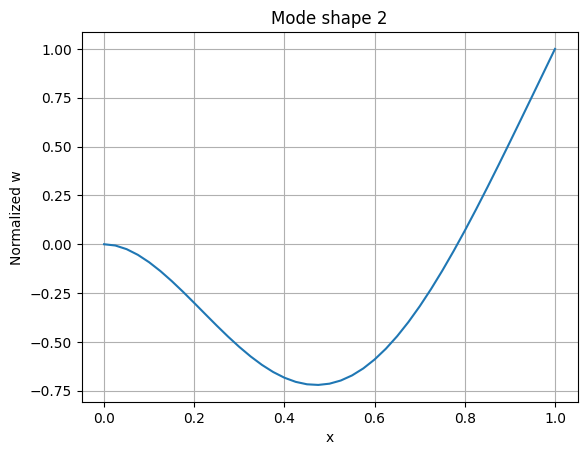

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# ============================================================
# Shape function L2 (2-node line element)
# ============================================================
def shapeFunctionL2(xi):
    N = np.array([
        0.5 * (1 - xi),
        0.5 * (1 + xi)
    ])
    dN_dxi = np.array([-0.5, 0.5])
    return N, dN_dxi


# ============================================================
# Timoshenko beam stiffness + mass
# ============================================================
def formStiffnessMassTimoshenkoBeam(GDoF, numberElements,
                                   elementNodes, numberNodes, xx,
                                   C, rho, I, thickness):

    K = np.zeros((GDoF, GDoF))
    M = np.zeros((GDoF, GDoF))

    # -------------------------
    # BENDING (2-point Gauss)
    # -------------------------
    gaussPts = np.array([ 0.577350269189626,
                         -0.577350269189626])
    gaussWts = np.ones(2)

    for e in range(numberElements):
        nodes = elementNodes[e] - 1
        elementDof = np.hstack([nodes, nodes + numberNodes])

        Le = xx[nodes[1]] - xx[nodes[0]]
        detJ = Le / 2
        invJ = 1 / detJ

        for q in range(2):
            N, dN_dxi = shapeFunctionL2(gaussPts[q])
            dN_dx = dN_dxi * invJ

            B = np.zeros((2, 4))
            B[0, 2:4] = dN_dx   # curvature term

            K[np.ix_(elementDof, elementDof)] += (
                B.T @ B * gaussWts[q] * detJ * C[0, 0]
            )

            # mass
            NN = np.outer(N, N) * gaussWts[q] * detJ
            M[np.ix_(nodes + numberNodes, nodes + numberNodes)] += NN * rho * I
            M[np.ix_(nodes, nodes)] += NN * rho * thickness

    # -------------------------
    # SHEAR (1-point Gauss)
    # -------------------------
    gaussPts = np.array([0.0])
    gaussWts = np.array([2.0])

    for e in range(numberElements):
        nodes = elementNodes[e] - 1
        elementDof = np.hstack([nodes, nodes + numberNodes])

        Le = xx[nodes[1]] - xx[nodes[0]]
        detJ = Le / 2
        invJ = 1 / detJ

        for q in range(1):
            N, dN_dxi = shapeFunctionL2(gaussPts[q])
            dN_dx = dN_dxi * invJ

            B = np.zeros((2, 4))
            B[1, 0:2] = dN_dx
            B[1, 2:4] = N

            K[np.ix_(elementDof, elementDof)] += (
                B.T @ B * gaussWts[q] * detJ * C[1, 1]
            )

    return K, M


# ============================================================
# MAIN – problem16vibrations.m
# ============================================================

# ---- Material & geometry ----
E = 1e7
poisson = 0.30
L = 1.0
thickness = 0.001

I = thickness**3 / 12
EI = E * I
kapa = 5 / 6
rho = 1
A = thickness

G = E / (2 * (1 + poisson))
C = np.array([
    [EI, 0],
    [0, kapa * thickness * G]
])

# ---- Mesh ----
numberElements = 40
xx = np.linspace(0, L, numberElements + 1)
numberNodes = len(xx)

elementNodes = np.zeros((numberElements, 2), dtype=int)
for i in range(numberElements):
    elementNodes[i] = [i + 1, i + 2]

GDoF = 2 * numberNodes

# ---- Assemble ----
K, M = formStiffnessMassTimoshenkoBeam(
    GDoF, numberElements,
    elementNodes, numberNodes, xx,
    C, rho, I, thickness
)

# ---- Boundary conditions (CANTILEVER – giống MATLAB) ----
fixedNodeW = np.array([1])
fixedNodeTX = np.array([1])

prescribedDof = np.hstack([
    fixedNodeW,
    fixedNodeTX + numberNodes
]) - 1

activeDof = np.setdiff1d(np.arange(GDoF), prescribedDof)

# ---- Eigenvalue problem ----
eigvals, eigvecs = eigh(
    K[np.ix_(activeDof, activeDof)],
    M[np.ix_(activeDof, activeDof)]
)

# ---- Non-dimensional frequencies (MATLAB style) ----
Omega = np.sqrt(eigvals) * L**2 * np.sqrt(rho * A / EI)
Omega = np.sort(Omega)

print("First 6 dimensionless frequencies Ω:")
print(Omega[:6])

# ---- Mode shapes (optional plot) ----
mode = 1
V = np.zeros(GDoF)
V[activeDof] = eigvecs[:, mode]

w_mode = V[:numberNodes]

plt.figure()
plt.plot(xx, w_mode / np.max(np.abs(w_mode)))
plt.xlabel("x")
plt.ylabel("Normalized w")
plt.title(f"Mode shape {mode+1}")
plt.grid(True)
plt.show()
